# Notebook to load a trained model and verify it on some images

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms.functional as TF
import numpy as np
from skimage.io import imread
import matplotlib.pyplot as plt
import sys
sys.path.append('../src')
from data_process import *
from u2net import *
from unet import *
from resnest import *


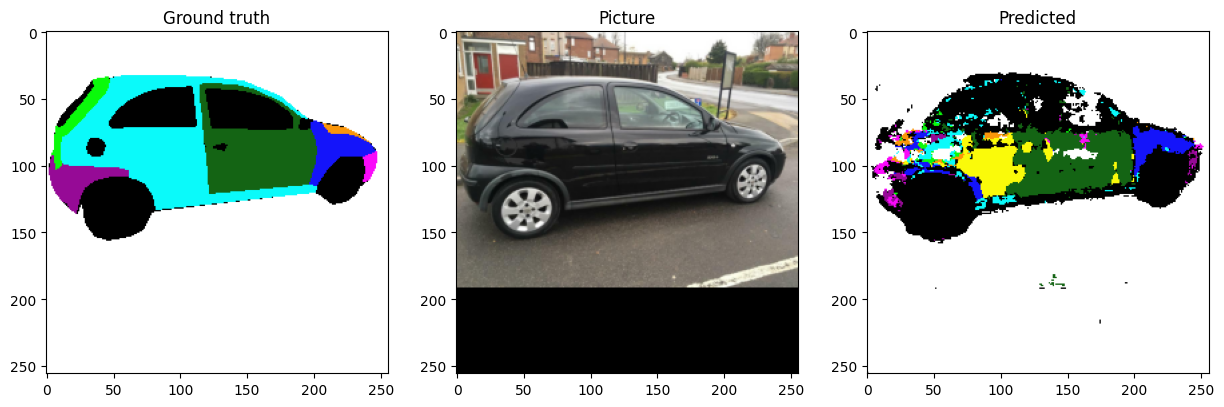

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model1 = torch.load("../trained_models/unet_model_350_loss_trian_0.00047_val_0.01216.pt", map_location=device)
model1.eval()

if __name__ =='__main__':
    random_car = "../data/random_car.jpg"
    ########## Connected ####################
    path_to_seg_img = "../data/test_data/array/image_09.npy"
    path_to_no_seg_img = "../data/test_data/image/image_9.png"
    reference = np.load(path_to_seg_img)[:,:,:3]
    ref_mask = np.load(path_to_seg_img)[:,:,3]
    #########################################
    
    ########## Connected ####################
    # path_to_seg_img = "../data/carseg_data/images/black_5_doors/with_segmentation/0230.png"
    # path_to_no_seg_img = "../data/carseg_data/images/black_5_doors/no_segmentation/0230.png"
    # reference = imread(path_to_no_seg_img)
    # ref_mask = imread(path_to_seg_img)
    #########################################
    
    imgA = imread(path_to_no_seg_img)
    imgA = resize_2_256(imgA)

    transform = transforms.Compose([transforms.ToTensor(),
                                    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                                                         std=[0.229, 0.224, 0.225])])
    imgA = transform(imgA)
    imgA = imgA.to(device)
    imgA = imgA.unsqueeze(0)
    # output1, _,_,_,_,_,_ = model1(imgA)

    output1 = model1(imgA)

    output_np1 = output1.cpu().detach().numpy().copy()  # output_np1.shape = (1, 10, 256, 256)
    output_np1 = (np.argmax(output_np1, axis=1) * 10).astype(np.uint8)
    plt.figure(figsize=(15, 10))
    plt.subplot(1, 3, 1)
    plt.title("Ground truth")
    plt.imshow(label_2_colour(ref_mask))
    # plt.imshow(ref_mask)
    plt.subplot(1, 3, 2)
    plt.title("Picture")
    plt.imshow(reference)
    plt.subplot(1, 3, 3)
    plt.title(f"Predicted")
    plt.imshow(label_2_colour(output_np1[0]))
